# Neighbourhood segmentation - without implementing Geo-Feature Method

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.geocoders import ArcGIS
nom = ArcGIS()
from sklearn.cluster import KMeans

In [119]:
data = pd.read_csv("Desktop/Beng/Train.csv")
data = data[:200]

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     200 non-null    object 
 1   availability  200 non-null    object 
 2   location      200 non-null    object 
 3   size          200 non-null    object 
 4   society       123 non-null    object 
 5   total_sqft    200 non-null    object 
 6   bath          198 non-null    float64
 7   balcony       187 non-null    float64
 8   price         200 non-null    float64
dtypes: float64(3), object(6)
memory usage: 14.2+ KB


## Taking Care of Missing Value - STEP 1

#### I have applied the strategy of filling the null values of numerical features with "mean" as this proved to be best approach other than filling null values with median, mode or simply 0. 

#### Feature - Society had to be dropped because missing values we more than 50% of instances.

In [120]:
data.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [121]:
bal_mean = data["balcony"].mean()
data["balcony"].fillna(bal_mean,inplace=True)


bat_mean = data["bath"].mean()
data["bath"].fillna(bat_mean,inplace=True)


data["size"] = data["size"].fillna(0)

data.drop("society",axis=1,inplace=True)

In [122]:
data.head()


,area_type,availability,location,size,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,1200,2.0,1.0,51.00


In [123]:
data.isnull().sum()

area_type       0
availability    0
location        0
size            0
total_sqft      0
bath            0
balcony         0
price           0
dtype: int64

## Feature Engineering - STEP 2

##### Converting availablity feature 

In [124]:
data["availability"].replace(['Immediate Possession','Ready To Move'],["21-Dec","21-Dec"],inplace=True)
def convert_availability(date):
    date = date
    date = date.replace("-"," ")
    date = date.split()
    s = " "
    year = str(int(date[0]) + 2000)
    month = str(date[1])
    s = year+" "+month
    return pd.to_datetime(s)

data["availability"] = data["availability"].apply(convert_availability)
data["availability"] =  pd.to_numeric(data["availability"])    

##### Converting area_type

#### As this is a Categorical Data - Ordinal Type, we will give ranks based on area type. 

In [125]:
def convert_area(area):
    if area == 'Super built-up  Area':
        return 3
    elif area == 'Built-up  Area':
        return 2
    elif area == 'Plot  Area':
        return 1

data["area_type"] = data["area_type"].apply(convert_area)

##### Converting Size 

In [126]:
def convert_size(size):
    size = str(size).split()
    return int(size[0])
data["size"]=  data["size"].apply(convert_size)

#### Converting sqft feature

In [127]:
def convert_sqft(sqft):
    sqft = sqft.split()
    if len(sqft)>1:
        return (int(sqft[0]) + int(sqft[2])) //2
    else:
        sqft = sqft[0]
        return sqft
    
data["total_sqft"] = data["total_sqft"].apply(convert_sqft)

### Final Data after feature Engineering

In [128]:
data.head()

,area_type,availability,location,size,total_sqft,bath,balcony,price
0,3,1575158400000000000,Electronic City Phase II,2,1056,2.0,1.0,39.07
1,1,1638316800000000000,Chikka Tirupathi,4,2600,5.0,3.0,120.00
2,2,1638316800000000000,Uttarahalli,3,1440,2.0,3.0,62.00
3,3,1638316800000000000,Lingadheeranahalli,3,1521,3.0,1.0,95.00
4,3,1638316800000000000,Kothanur,2,1200,2.0,1.0,51.00


In [129]:
index = data[(data["area_type"] != 3) & (data["area_type"] != 2) & (data["area_type"] != 1)].index
data["area_type"].loc[index] = 0

/var/folders/4n/twdpcmq10zn6ffq7fk64wsy40000gn/T/ipykernel_62164/2427473314.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["area_type"].loc[index] = 0


In [130]:
data["area_type"].unique()

array([3, 1, 2])

### Now there are two ways of dealing with the location feature :
#### 1) Droping the column entirely - This won't prove efficient because in location feature in real life has huge impact on price.
#### 2) Creating Dummy Variables for each instances - Let's give it a try

In [131]:
dummy_data = pd.get_dummies(data=data)

In [132]:
dummy_data.head(5)

,area_type,availability,size,bath,balcony,price,location_ Devarachikkanahalli,location_ Mysore Highway,location_ Thanisandra,location_7th Phase JP Nagar,...,total_sqft_845,total_sqft_869,total_sqft_880,total_sqft_890,total_sqft_945,total_sqft_950,total_sqft_957,total_sqft_966,total_sqft_970,total_sqft_980
0,3,1575158400000000000,2,2.0,1.0,39.07,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1638316800000000000,4,5.0,3.0,120.00,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,1638316800000000000,3,2.0,3.0,62.00,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,1638316800000000000,3,3.0,1.0,95.00,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3,1638316800000000000,2,2.0,1.0,51.00,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [133]:
x = dummy_data.drop("price",axis=1)
y = dummy_data["price"]

### Applying Superivised learning Algorithm - Regression to train the model

#### Spliting dataset into train-test

In [134]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=42,random_state=42)

#### Using StandardScaling to make all the values homogenous. (mean = 0  and std = 1)

In [135]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
x_train_scaled = sc.fit_transform(x_train)
x_test_scaled = sc.transform(x_test)

#### Training model 

In [136]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train_scaled,y_train)

LinearRegression()

In [137]:
y_pred = model.predict(x_test_scaled)

#### evaluating the results (y_pred) with original (y_test)

In [138]:
y_pred = model.predict(x_test_scaled)
from sklearn.metrics import mean_absolute_error,mean_squared_error
mae_1 = mean_absolute_error(y_pred,y_test)
mse_1 = mean_squared_error(y_pred,y_test)
rmse_1 = np.sqrt(mse_1)
print(f"The Mean Absolute Error - {mae_1}")
print(f"The Mean Squared Error - {mse_1}")
print(f"The Root Mean Squared Error - {rmse_1}")

The Mean Absolute Error - 35152613638355.945
The Mean Squared Error - 5.211481749764407e+27
The Root Mean Squared Error - 72190593222139.45


### Visualising the results

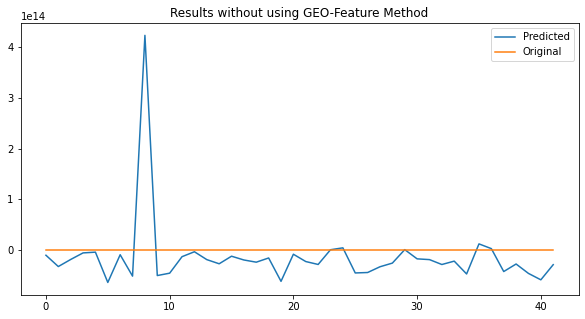

In [139]:
plt.figure(figsize=(10,5))
plt.title("Results without using GEO-Feature Method")
plt.plot(range(len(y_pred[:100])),y_pred,label="Predicted")
plt.plot(range(len(y_test[:100])),y_test,label="Original")
plt.legend()

# Predicting Price With implementing Geo-Feature Method

In [140]:
from geopy.geocoders import Nominatim

loc = Nominatim(user_agent="GetLoc")


 

In [141]:
class Feature_engineering:
    def __init__(self,data,column):
        self.data = data
        self.column = column
    
    
    
    def get_k_value(self):
        series = self.data[self.column]
        coordinates_x = []
        coordinates_y = []

        for i in range(len(series)):
            locations = nom.geocode(series[i])

            if locations is None:
                coordinates_x.append(0)
                coordinates_y.append(0)
            elif locations is not None:
                coordinates_x.append(locations[1][0])
                coordinates_y.append(locations[1][1])

        d = {"x":coordinates_x,"y":coordinates_y}
        x = pd.DataFrame(data=d)
        from sklearn.preprocessing import StandardScaler
        sc = StandardScaler()
        new_data = sc.fit_transform(x)
        self.new_data = new_data

#         from sklearn.cluster import KMeans
        ssd =[]
        for i in range(2,10):
            kmeans = KMeans(n_clusters=i)
            kmeans.fit(new_data)
            ssd.append(kmeans.inertia_)
        plt.plot(range(2,10),ssd)
        
        
    def fit_model(self,k_value):
        model = KMeans(n_clusters = k_value)
        y_pred = model.fit_predict(self.new_data)
        data[self.column] = y_pred
        return data
   

In [142]:
data.head()

,area_type,availability,location,size,total_sqft,bath,balcony,price
0,3,1575158400000000000,Electronic City Phase II,2,1056,2.0,1.0,39.07
1,1,1638316800000000000,Chikka Tirupathi,4,2600,5.0,3.0,120.00
2,2,1638316800000000000,Uttarahalli,3,1440,2.0,3.0,62.00
3,3,1638316800000000000,Lingadheeranahalli,3,1521,3.0,1.0,95.00
4,3,1638316800000000000,Kothanur,2,1200,2.0,1.0,51.00


In [143]:
geo_featuring = Feature_engineering(data,"location")

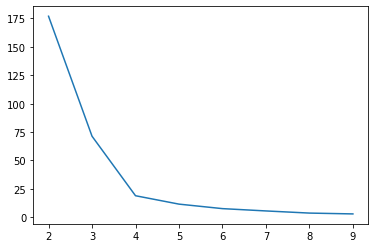

In [144]:
geo_featuring.get_k_value()

In [145]:
geo_featuring.fit_model(4)

,area_type,availability,location,size,total_sqft,bath,balcony,price
0,3,1575158400000000000,0,2,1056,2.0,1.0,39.07
1,1,1638316800000000000,0,4,2600,5.0,3.0,120.00
2,2,1638316800000000000,0,3,1440,2.0,3.0,62.00
3,3,1638316800000000000,0,3,1521,3.0,1.0,95.00
4,3,1638316800000000000,0,2,1200,2.0,1.0,51.00
...,...,...,...,...,...,...,...,...
195,3,1638316800000000000,0,2,1327,2.0,2.0,98.00
196,3,1638316800000000000,0,2,1186,2.0,2.0,58.00
197,2,1638316800000000000,0,3,1783,3.0,1.0,115.00
198,3,1638316800000000000,0,3,1400,3.0,2.0,56.00


In [146]:
geo_feature_data = geo_featuring.fit_model(4)

In [147]:
x = geo_feature_data.drop("price",axis=1)
y = geo_feature_data["price"]

In [148]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=42,random_state=42)

In [149]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
x_train_scaled = sc.fit_transform(x_train)
x_test_scaled = sc.transform(x_test)

In [150]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train_scaled,y_train)

LinearRegression()

In [151]:
y_pred = model.predict(x_test_scaled)
from sklearn.metrics import mean_absolute_error,mean_squared_error
mae_2 = mean_absolute_error(y_pred,y_test)
mse_2 = mean_squared_error(y_pred,y_test)
rmse_2 = np.sqrt(mse_2)
print(f"The Mean Absolute Error - {mae_2}")
print(f"The Mean Squared Error - {mse_2}")
print(f"The Root Mean Squared Error - {rmse_2}")

The Mean Absolute Error - 39.51510855580899
The Mean Squared Error - 4391.036894959502
The Root Mean Squared Error - 66.26489941861756


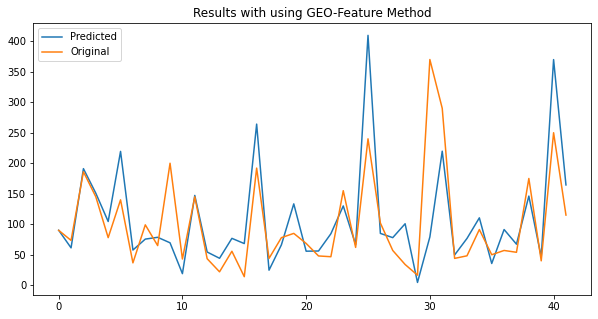

In [154]:
plt.figure(figsize=(10,5))
plt.title("Results with using GEO-Feature Method")
plt.plot(range(len(y_pred[:100])),y_pred,label="Predicted")
plt.plot(range(len(y_test[:100])),y_test,label="Original")
plt.legend()

### Final Results Comparison

In [153]:
mse = [mse_1,mse_2]
mae = [mae_1,mae_2]
rmse = [rmse_1,rmse_2]

pd.DataFrame(data=[mse,mae,rmse],columns=["Normal-Method","GEO-Featuring"],index =["MSE","MAE","RMSE"])


,Normal-Method,GEO-Featuring
MSE,5.211482e+27,4391.036895
MAE,3.515261e+13,39.515109
RMSE,7.219059e+13,66.264899
